In [11]:
import pandas as pd
import sys
import os

In [12]:
# Get the absolute path of the directory where the notebook is currently running
# This usually is /path/to/app/folder_notebook
notebook_dir = os.getcwd()

# Get the absolute path of the 'app' directory (parent of folder_notebook)
main_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
db_path = os.path.join(main_dir, 'data', 'planet_fone.db')
model_path = os.path.join(main_dir, 'models')
if main_dir not in sys.path:
    sys.path.append(main_dir)

from utils.sql import get_table

In [23]:
def _generate_features(
    codes: list = None,
    n_random: int = None,
    year: int = 2026,
    seed: int = None,
    verbose: bool = False
) -> pd.DataFrame:
    """
    Generate features for a sequence of circuits.

    Parameters:
        codes (list): List of circuit codes to use as the calendar. If None, random circuits are selected.
        n_random (int): Number of random circuits to select if codes is None.
        year (int): The year for which to generate features (used to compute 'from_thirty').
        seed (int): Random seed for reproducibility when sampling random circuits.
        verbose (bool): If True, prints information about the process.

    Returns:
        pd.DataFrame: DataFrame containing features for each leg in the calendar.
    """

    travel_logistics_df = get_table(table_name="travel_logistic", db_path=db_path)
    fone_geography_df = get_table(table_name="fone_geography", db_path=db_path)
    fone_calendar_df = get_table(table_name="fone_calendar", db_path=db_path)
    
    fone_calendar_df = fone_calendar_df[fone_calendar_df['year'] == year]

    if year is not None:
        from_thirty = 2030 - year

    if n_random is not None and n_random > 0 and codes is None:
        if seed is None:
            seed = 42
        calendar = fone_geography_df['code_6'].sample(n_random, random_state=seed).to_list()
        if verbose:
            print(f"Randomly selected {n_random} circuits: {calendar}")
    elif codes is not None:
        calendar = list(codes)
        if verbose:
            print(f"Using provided codes: {calendar}")
    else:
        raise ValueError("Either 'codes' must be provided or 'n_random' must be > 0.")

    legs = [{'from_circuit': calendar[i],
             'to_circuit': calendar[i + 1]} for i in range(len(calendar) - 1)]
    legs = pd.DataFrame(legs)
    legs['codes'] = legs['from_circuit'].astype(str) + '-' + legs['to_circuit'].astype(str)

    features_df = travel_logistics_df[travel_logistics_df['codes'].isin(legs['codes'])].set_index('codes').loc[legs['codes']].reset_index()
    features_df = features_df.rename(columns={"truck_viable": "truck_feasible", "distance_km": "air_distance_km"})
    features_df = features_df.drop(columns=['needs_air', 'transport_mode', 'effort_score', "air_emissions", "truck_emissions"])

    features_df['from_thirty'] = from_thirty
    
    features_df = features_df.merge(
        fone_geography_df[['id','code_6', 'latitude', 'longitude']],
        left_on='from_id',
        right_on='id',
        how='left',
        suffixes=('', '_from')
    ).rename(columns={'code_6': 'from_code', 'latitude': 'from_latitude', 'longitude': 'from_longitude'})
    features_df = features_df.merge(
        fone_geography_df[['id','code_6', 'latitude', 'longitude']],
        left_on='to_id',
        right_on='id',
        how='left',
        suffixes=('', '_to')
    ).rename(columns={'code_6': 'to_code', 'latitude': 'to_latitude', 'longitude': 'to_longitude'})

    features_df = features_df.drop(columns=['from_id', 'to_id', 'id_from', 'id_to','from_code', 'to_code'])
    if codes is not None:
        features_df['n_circuits'] = len(codes)
    else:
        features_df['n_circuits'] = n_random

    return features_df

In [14]:
# this func is an example of how to use the function and gives you test data to play around with
generate_features(n_random=20)

2025-05-25 13:15:36,113 - INFO - get_table - Executing function: get_table
2025-05-25 13:15:36,133 - INFO - get_table - Completed function: get_table
2025-05-25 13:15:36,134 - INFO - get_table - Executing function: get_table
2025-05-25 13:15:36,138 - INFO - get_table - Completed function: get_table
2025-05-25 13:15:36,138 - INFO - get_table - Executing function: get_table
2025-05-25 13:15:36,148 - INFO - get_table - Completed function: get_table


,codes,id,from_circuit,to_circuit,air_distance_km,truck_distance_km,truck_feasible,from_thirty,from_latitude,from_longitude,to_latitude,to_longitude,n_circuits
0,SINMAR-NOROSL,656,Marina Bay,Oslo,10056.660499,NaN,0,4,1.2914,103.8645,59.9139,10.7522,20
1,NOROSL-CANVAN,2162,Oslo,Vancouver,7181.440994,NaN,0,4,59.9139,10.7522,49.2827,-123.1207,20
2,CANVAN-NIGLAG,2254,Vancouver,Lagos,11944.624001,NaN,0,4,49.2827,-123.1207,6.5244,3.3792,20
3,NIGLAG-AZEBAK,2086,Lagos,Baku,5948.505734,NaN,0,4,6.5244,3.3792,40.3725,49.8533,20
4,AZEBAK-QATLUS,826,Baku,Lusail,1661.348675,2653.10,0,4,40.3725,49.8533,25.4914,51.4542,20
5,QATLUS-FRALEC,1296,Lusail,Le Castellet,4562.222550,NaN,0,4,25.4914,51.4542,43.2500,5.7917,20
6,FRALEC-SPAVAL,1248,Le Castellet,Valencia,662.196920,893.36,1,4,43.2500,5.7917,39.4589,-0.3317,20
7,SPAVAL-MONMON,1206,Valencia,Monte Carlo,800.431221,1026.77,1,4,39.4589,-0.3317,43.7347,7.4206,20
8,MONMON-FRAMAG,1477,Monte Carlo,Magny Cours,481.490750,742.77,1,4,43.7347,7.4206,46.8642,3.1633,20
9,FRAMAG-GERHOC,906,Magny Cours,Hockenheim,485.629655,678.19,1,4,46.8642,3.1633,49.3249,8.5694,20


In [24]:
def fetch_training_data(verbose=False, ) -> pd.DataFrame:
    """
    Fetches and prepares training data for regression models by merging calendar and geography data,
    generating features, and splitting the dataset into air and truck-feasible subsets.
    The function filters calendar data for entries with positive emissions, merges with geography data,
    generates features for each year, and concatenates the results. It then splits the final dataset
    into two sets: one for air routes (where 'truck_feasible' is False) and one for truck-feasible routes
    (where 'truck_feasible' is True).
    Parameters:
        verbose (bool, optional): If True, logs detailed progress information using the provided logger.
        logger (logging.Logger, optional): Logger instance to use for logging progress if verbose is True.
    Returns:
        tuple:
            - training_set_air (pd.DataFrame): Training data for air routes (truck_feasible == False).
            - training_set_truck (pd.DataFrame): Training data for truck-feasible routes (truck_feasible == True).
    """

    fone_calendar_df = get_table(table_name="fone_calendar", db_path=db_path)
    fone_geography_df = get_table(table_name="fone_geography", db_path=db_path)

    fone_calendar_df = fone_calendar_df[fone_calendar_df['leg_emissions'] > 0]

    training_data = pd.DataFrame()
    for year in fone_calendar_df['year'].unique():
        year_data = fone_calendar_df[fone_calendar_df['year'] == year]
        if len(year_data) > 0:
            codes = year_data.merge(fone_geography_df, how='left', left_on='geo_id', right_on='id')[['code_6','leg_emissions','outbound_route']]
            if verbose:
                print(f"Year {year}: {len(codes)} codes")
            features = _generate_features(codes=codes['code_6'].tolist(), year=year, verbose=verbose)
            features = features.merge(codes, how='left', left_on='id', right_on='outbound_route')
            
            training_data = pd.concat([training_data, features], ignore_index=True)

    training_data = training_data.drop(columns=['id', 'outbound_route', 'code_6'])
    if verbose:
        print(f"Total training samples: {len(training_data)}")

    training_set_air = training_data[training_data['truck_feasible'] == False].copy()
    training_set_truck = training_data[training_data['truck_feasible'] == True].copy()

    return training_set_air, training_set_truck

In [25]:
fetch_training_data( verbose=True) # this is the new training dataset

2025-05-25 13:18:54,388 - INFO - get_table - Executing function: get_table
2025-05-25 13:18:54,393 - INFO - get_table - Completed function: get_table
2025-05-25 13:18:54,394 - INFO - get_table - Executing function: get_table
2025-05-25 13:18:54,394 - INFO - get_table - Completed function: get_table
Year 2000: 16 codes
2025-05-25 13:18:54,403 - INFO - get_table - Executing function: get_table
2025-05-25 13:18:54,419 - INFO - get_table - Completed function: get_table
2025-05-25 13:18:54,420 - INFO - get_table - Executing function: get_table
2025-05-25 13:18:54,424 - INFO - get_table - Completed function: get_table
2025-05-25 13:18:54,425 - INFO - get_table - Executing function: get_table
2025-05-25 13:18:54,431 - INFO - get_table - Completed function: get_table
Using provided codes: ['AUSMEL', 'BRASAO', 'ITAIMO', 'UKGSIL', 'SPACAT', 'GERNüR', 'MONMON', 'CANMON', 'FRAMAG', 'AUSSPI', 'GERHOC', 'HUNBUD', 'BELSPA', 'ITAMON', 'USAIND', 'JAPSUZ']
Year 2001: 16 codes
2025-05-25 13:18:54,445 - I

(             codes from_circuit    to_circuit  air_distance_km  \
 0    AUSMEL-BRASAO    Melbourne     São Paulo     13062.910869   
 1    BRASAO-ITAIMO    São Paulo         Imola      9612.464691   
 6    MONMON-CANMON  Monte Carlo      Montreal      6121.731961   
 7    CANMON-FRAMAG     Montreal   Magny Cours      5658.437270   
 13   ITAMON-USAIND        Monza  Indianapolis      7345.695116   
 ..             ...          ...           ...              ...   
 388  AZEBAK-SINMAR         Baku    Marina Bay      6946.668872   
 389  SINMAR-USAAUS   Marina Bay        Austin     15842.999006   
 391  MEXMEX-BRASAO  Mexico City     São Paulo      7430.971654   
 392  BRASAO-USALAS    São Paulo     Las Vegas      9788.539873   
 393  USALAS-QATLUS    Las Vegas        Lusail     13015.791834   
 
      truck_distance_km  truck_feasible  from_thirty  from_latitude  \
 0                  NaN               0           30       -37.8497   
 1                  NaN               0           30

In [17]:
training_set = fetch_training_data( verbose=True)
training_set.to_clipboard(index=False)  # Copy the training set to clipboard for easy pasting elsewhere

2025-05-25 13:15:45,639 - INFO - get_table - Executing function: get_table
2025-05-25 13:15:45,645 - INFO - get_table - Completed function: get_table
2025-05-25 13:15:45,646 - INFO - get_table - Executing function: get_table
2025-05-25 13:15:45,649 - INFO - get_table - Completed function: get_table
Year 2000: 16 codes
2025-05-25 13:15:45,652 - INFO - get_table - Executing function: get_table
2025-05-25 13:15:45,666 - INFO - get_table - Completed function: get_table
2025-05-25 13:15:45,667 - INFO - get_table - Executing function: get_table
2025-05-25 13:15:45,671 - INFO - get_table - Completed function: get_table
2025-05-25 13:15:45,672 - INFO - get_table - Executing function: get_table
2025-05-25 13:15:45,678 - INFO - get_table - Completed function: get_table
Using provided codes: ['AUSMEL', 'BRASAO', 'ITAIMO', 'UKGSIL', 'SPACAT', 'GERNüR', 'MONMON', 'CANMON', 'FRAMAG', 'AUSSPI', 'GERHOC', 'HUNBUD', 'BELSPA', 'ITAMON', 'USAIND', 'JAPSUZ']
Year 2001: 16 codes
2025-05-25 13:15:45,681 - I

In [20]:
training_set.head(1)

,codes,from_circuit,to_circuit,air_distance_km,truck_distance_km,truck_feasible,from_thirty,from_latitude,from_longitude,to_latitude,to_longitude,n_circuits,leg_emissions
0,AUSMEL-BRASAO,Melbourne,São Paulo,13062.910869,NaN,0,30,-37.8497,144.968,-23.7036,-46.6997,16,21341.54586


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def train_regression_model(training_set=None):
    """
    Train a regression model on the training data.
    Returns the trained model, feature names, feature importances, and model performance metrics.
    Also plots relevant charts for linear regression.
    """
    if training_set is None:
        raise ValueError("Training set must be provided.")

    # Select features for the regression
    if 'air_distance_km' not in training_set.columns and 'truck_distance_km' not in training_set.columns:
        raise ValueError("Training set must contain 'air_distance_km' or 'truck_distance_km' columns.")
    if 'air_distance_km' in training_set.columns:
        selected_features = training_set[['from_circuit', 'to_circuit', 'air_distance_km', 'from_thirty','n_circuits']].copy()
        numerical_columns = ['air_distance_km', 'from_thirty', 'n_circuits']
    else:
        selected_features = training_set[['from_circuit', 'to_circuit', 'truck_distance_km', 'from_thirty','n_circuits']].copy()
        numerical_columns = ['truck_distance_km', 'from_thirty', 'n_circuits']
        
        
    selected_features = selected_features.fillna(0)

    # scale numerical features
    scaler = StandardScaler()
    selected_features[numerical_columns] = scaler.fit_transform(
        selected_features[numerical_columns]
    ) 


    # Assign feature and target variables
    X = selected_features.drop(['from_circuit', 'to_circuit'], axis='columns')
    y = training_set['leg_emissions'].values.flatten()

    # Split into test and remaining set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Split into train and val set
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of total
    )

    # Train the linear model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    print('Linear model trained')

    # Run predictions on the model
    y_train_pred = lr_model.predict(X_train)
    y_val_pred = lr_model.predict(X_val)
    y_test_pred = lr_model.predict(X_test)

    # Evaluate the regression model
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"Training MSE: {train_mse:.2f}")
    print(f"Validation MSE: {val_mse:.2f}")
    print(f"Testing MSE: {test_mse:.2f}")
    print(f"Training R²: {train_r2:.3f}")
    print(f"Validation R²: {val_r2:.2f}")
    print(f"Testing R²: {test_r2:.2f}")
    print(f"Testing MAE: {test_mae:.2f}")

    # Feature importance for linear regression is the absolute value of coefficients
    feature_names = X.columns.tolist()
    feature_importance = np.abs(lr_model.coef_)

    # Plotting: Feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_importance)
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Feature Importances (Linear Regression)')
    plt.tight_layout()
    plt.show()

    # Plotting: Predicted vs Actual for test set
    plt.figure(figsize=(7, 7))
    plt.scatter(y_test, y_test_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Emissions')
    plt.ylabel('Predicted Emissions')
    plt.title('Actual vs Predicted Emissions (Test Set)')
    plt.tight_layout()
    plt.show()

    # Plotting: Residuals
    residuals = y_test - y_test_pred
    plt.figure(figsize=(8, 5))
    plt.hist(residuals, bins=30, edgecolor='k')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution (Test Set)')
    plt.tight_layout()
    plt.show()

    # Explanation of features
    feature_explanation = {
        'air_distance_km': 'Great-circle distance between circuits (km)',
        'truck_distance_km': 'Truck route distance between circuits (km)',
        'truck_feasible': 'Whether truck transport is feasible (1=yes, 0=no)',
        'from_thirty': 'years until 2030 from the simulated year',
        'from_latitude': 'Latitude of from_circuit',
        'from_longitude': 'Longitude of from_circuit',
        'to_latitude': 'Latitude of to_circuit',
        'to_longitude': 'Longitude of to_circuit',
        'delta_latitude': 'Difference in latitude (to - from)',
        'delta_longitude': 'Difference in longitude (to - from)'
    }

    # Return all relevant outputs
    performance = {
        'train_mse': train_mse,
        'val_mse': val_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'test_r2': test_r2,
        'test_mae': test_mae
    }

    return lr_model, feature_names, feature_importance, performance, feature_explanation



def leg_regression(df, model, from_circuit_encoder, to_circuit_encoder):
    """
    Apply the trained regression model to predict leg emissions for a DataFrame.
    Returns the DataFrame with a new 'predicted_leg_emissions' column.
    """
    # Get trained model and encoders from the parameters
    if model is None or from_circuit_encoder is None or to_circuit_encoder is None:
        raise ValueError("Model and encoders must be provided for prediction.")
   
    
    # Create a copy of the input DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # Check which columns are available and create missing ones with default values
    required_columns = ['from_circuit', 'to_circuit', 'air_distance_km', 'truck_distance_km', 'truck_feasible', 'from_thirty',
                        'from_latitude', 'from_longitude', 'to_latitude', 'to_longitude']
    numerical_columns = ['air_distance_km', 'truck_distance_km','from_thirty','from_latitude', 'from_longitude', 'to_latitude', 'to_longitude', 'delta_latitude', 'delta_longitude']

    print(f"Available columns in DataFrame: {list(df_copy.columns)}")
    print(f"Required columns: {required_columns}")
    
    for col in required_columns:
        if col not in df_copy.columns:
            print(f"Warning: Column '{col}' not found. Creating with default value 0.")
            df_copy[col] = 0
    
    # Select and prepare features (same as training)
    selected_features = df_copy[required_columns]
    selected_features = selected_features.fillna(0)
    
    # Convert bool features to int
    selected_features['truck_feasible'] = selected_features['truck_feasible'].astype(int)
    selected_features['from_thirty'] = selected_features['from_thirty'].astype(int)
    
    # Creating delta coordinates for better model performance
    selected_features['delta_latitude'] = selected_features['to_latitude'] - selected_features['from_latitude']
    selected_features['delta_longitude'] = selected_features['to_longitude'] - selected_features['from_longitude']
    
    # Scale Coordinates
    scaler = StandardScaler()
    selected_features[numerical_columns] = scaler.fit_transform(
        selected_features[numerical_columns]
    )
    
    # # Encode circuit names using the same encoders from training
    # from_circuit_df = pd.DataFrame(selected_features['from_circuit'])
    # encoded_fc = from_circuit_encoder.transform(from_circuit_df[['from_circuit']])
    # from_circuit_columns = ["from_circuit" + category for category in list(from_circuit_encoder.categories_[0])]
    # encoded_fc = pd.DataFrame(encoded_fc, columns=from_circuit_columns)
    # selected_features = pd.concat([selected_features, encoded_fc], axis=1)
    
    # to_circuit_df = pd.DataFrame(selected_features['to_circuit'])
    # encoded_tc = to_circuit_encoder.transform(to_circuit_df[['to_circuit']])
    # to_circuit_columns = ["to_circuit" + category for category in list(to_circuit_encoder.categories_[0])]
    # encoded_tc = pd.DataFrame(encoded_tc, columns=to_circuit_columns)
    # selected_features = pd.concat([selected_features, encoded_tc], axis=1)
    
    # Prepare features for prediction
    X = selected_features.drop(['from_circuit', 'to_circuit'], axis='columns')
    
    # Make predictions
    predictions = model.predict(X)
    
    # Ensure no negative predictions (clip to 0 minimum)
    predictions = np.maximum(predictions, 0)
    
    # Check if any predictions were negative before clipping
    negative_count = np.sum(model.predict(X) < 0)
    if negative_count > 0:
        print(f"Warning: {negative_count} out of {len(predictions)} predictions were negative and have been clipped to 0.")
    
    # Add predictions to the original DataFrame
    df_copy['predicted_leg_emissions'] = predictions
    
    return df_copy

In [26]:
air, truck = fetch_training_data(verbose=True)

2025-05-25 13:19:58,643 - INFO - get_table - Executing function: get_table
2025-05-25 13:19:58,647 - INFO - get_table - Completed function: get_table
2025-05-25 13:19:58,647 - INFO - get_table - Executing function: get_table
2025-05-25 13:19:58,647 - INFO - get_table - Completed function: get_table
Year 2000: 16 codes
2025-05-25 13:19:58,647 - INFO - get_table - Executing function: get_table
2025-05-25 13:19:58,667 - INFO - get_table - Completed function: get_table
2025-05-25 13:19:58,668 - INFO - get_table - Executing function: get_table
2025-05-25 13:19:58,671 - INFO - get_table - Completed function: get_table
2025-05-25 13:19:58,671 - INFO - get_table - Executing function: get_table
2025-05-25 13:19:58,678 - INFO - get_table - Completed function: get_table
Using provided codes: ['AUSMEL', 'BRASAO', 'ITAIMO', 'UKGSIL', 'SPACAT', 'GERNüR', 'MONMON', 'CANMON', 'FRAMAG', 'AUSSPI', 'GERHOC', 'HUNBUD', 'BELSPA', 'ITAMON', 'USAIND', 'JAPSUZ']
Year 2001: 16 codes
2025-05-25 13:19:58,688 - I

In [29]:
training_set = pd.concat([air, truck], ignore_index=True)

training_set

,codes,from_circuit,to_circuit,air_distance_km,truck_distance_km,truck_feasible,from_thirty,from_latitude,from_longitude,to_latitude,to_longitude,n_circuits,leg_emissions
0,AUSMEL-BRASAO,Melbourne,São Paulo,13062.910869,NaN,0,30,-37.8497,144.9680,-23.7036,-46.6997,16,21341.545860
1,BRASAO-ITAIMO,São Paulo,Imola,9612.464691,NaN,0,30,-23.7036,-46.6997,44.3439,11.7167,16,15704.375394
2,MONMON-CANMON,Monte Carlo,Montreal,6121.731961,NaN,0,30,43.7347,7.4206,45.5000,-73.5228,16,10001.386728
3,CANMON-FRAMAG,Montreal,Magny Cours,5658.437270,NaN,0,30,45.5000,-73.5228,46.8642,3.1633,16,9244.478486
4,ITAMON-USAIND,Monza,Indianapolis,7345.695116,NaN,0,30,45.6156,9.2811,39.7876,-86.2392,16,12001.037958
...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,UKGSIL-HUNBUD,Silverstone,Budapest,1531.281371,1884.00,1,6,52.0786,-1.0169,47.5789,19.2486,23,172.159172
390,HUNBUD-BELSPA,Budapest,Spa-Francorchamps,1017.609687,1281.37,1,6,47.5789,19.2486,50.4455,5.9708,23,117.091082
391,BELSPA-NETZAN,Spa-Francorchamps,Zandvoort,238.527132,298.66,1,6,50.4455,5.9708,52.3888,4.5409,23,27.291432
392,NETZAN-ITAMON,Zandvoort,Monza,828.289425,1117.47,1,6,52.3888,4.5409,45.6156,9.2811,23,102.113965


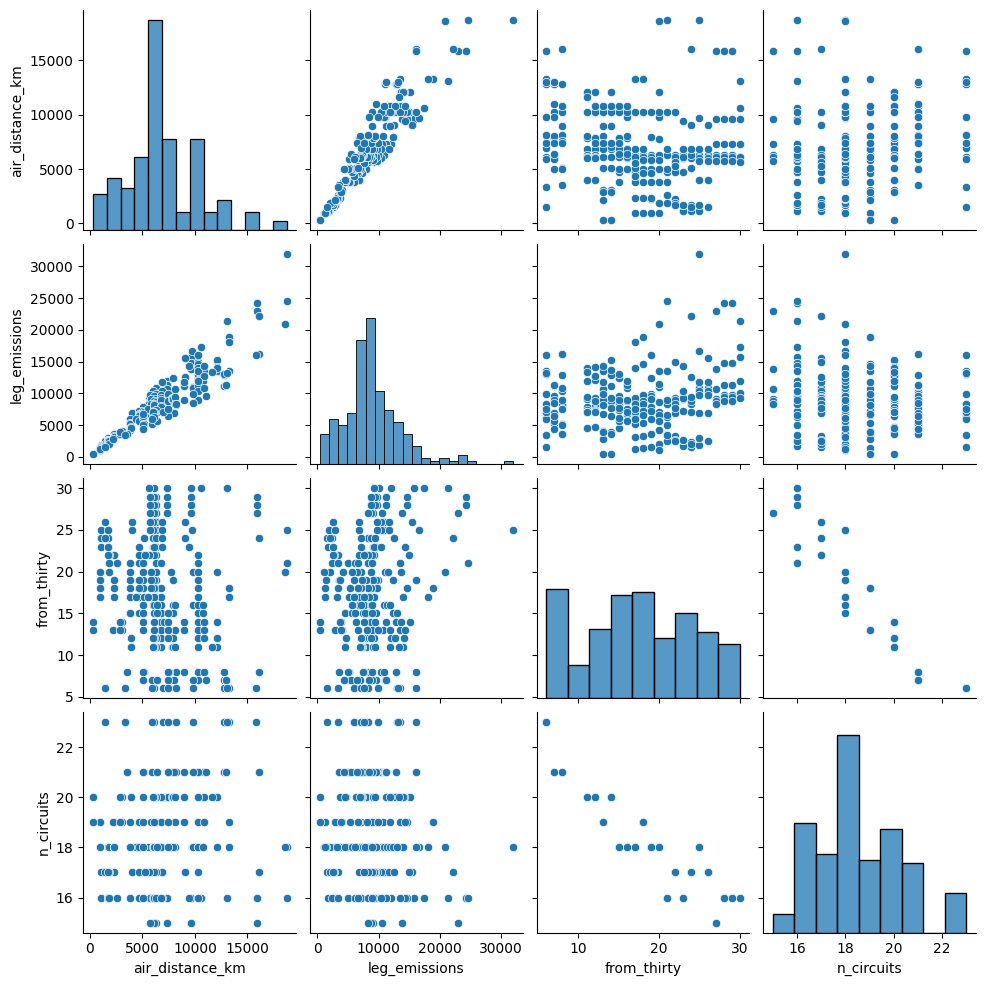

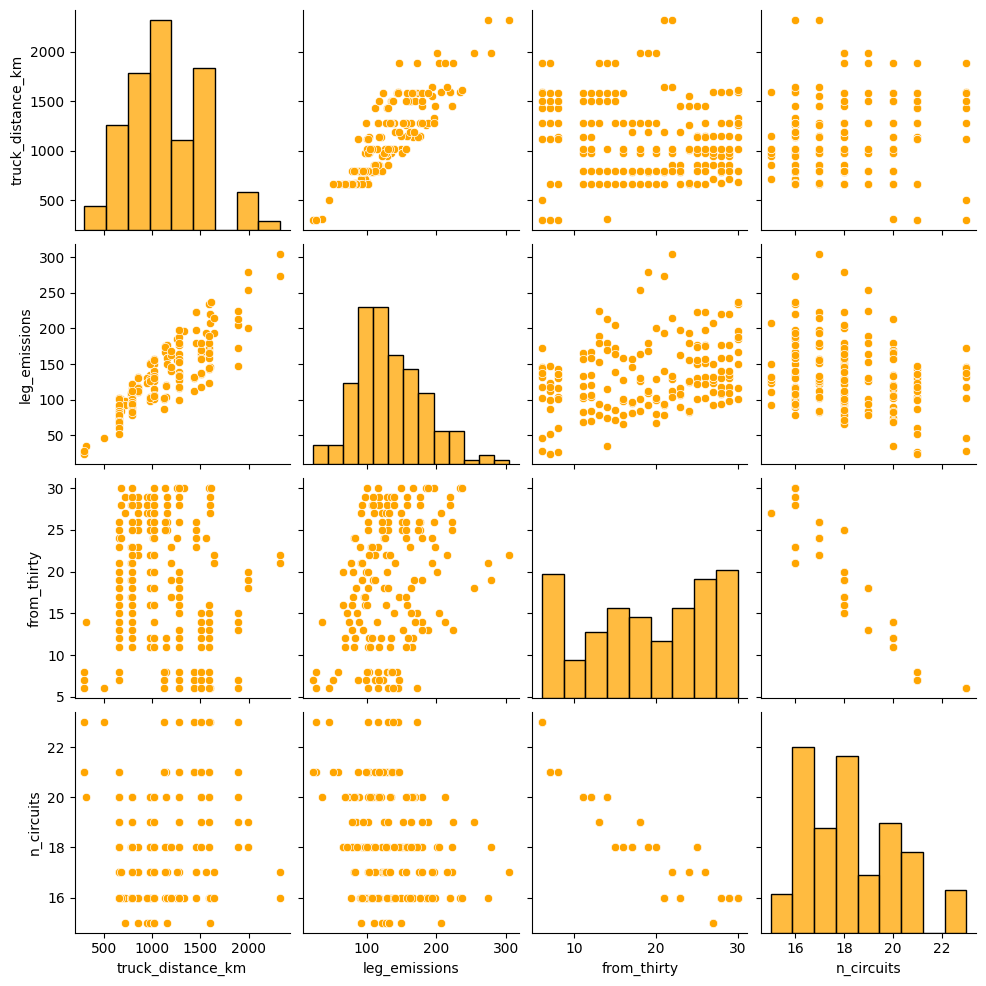

In [33]:
training_set_air = training_set[training_set['truck_feasible'] == False].copy()
training_set_truck = training_set[training_set['truck_feasible'] == True].copy()
sns.pairplot(training_set_air[[ 'air_distance_km', 'leg_emissions','from_thirty','n_circuits']])
sns.pairplot(
    training_set_truck[['truck_distance_km', 'leg_emissions', 'from_thirty', 'n_circuits']],
    plot_kws={'color': 'orange'},
    diag_kws={'color': 'orange'}
)

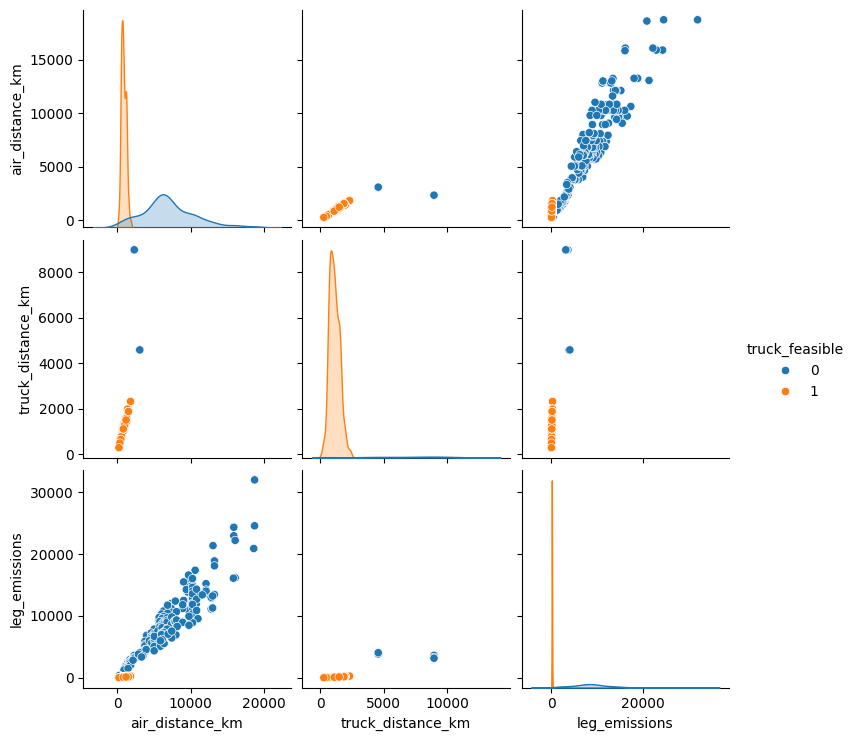

In [31]:
import seaborn as sns
sns.pairplot(training_set, hue='truck_feasible', vars=['air_distance_km', 'truck_distance_km', 'leg_emissions'])

In [ ]:
training_set_air = training_set_air.drop(columns=['from_latitude', 'from_longitude', 'to_latitude', 'to_longitude','truck_feasible','truck_distance_km'])
training_set_truck = training_set_truck.drop(columns=['air_distance_km', 'truck_feasible','from_latitude', 'from_longitude', 'to_latitude', 'to_longitude'])

Linear model trained
Training MSE: 275.54
Validation MSE: 198.12
Testing MSE: 154.60
Training R²: 0.887
Validation R²: 0.92
Testing R²: 0.92
Testing MAE: 10.18


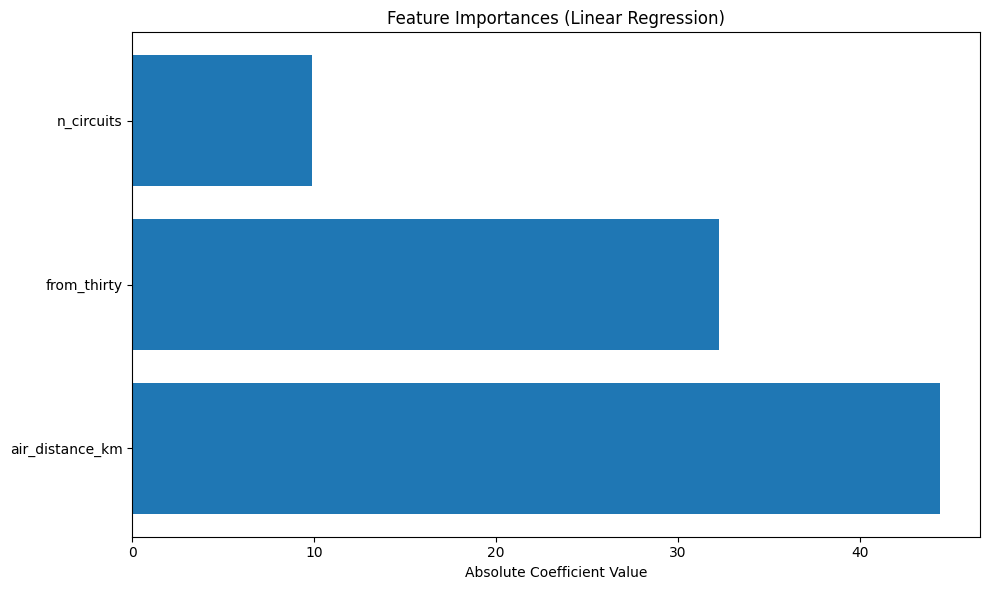

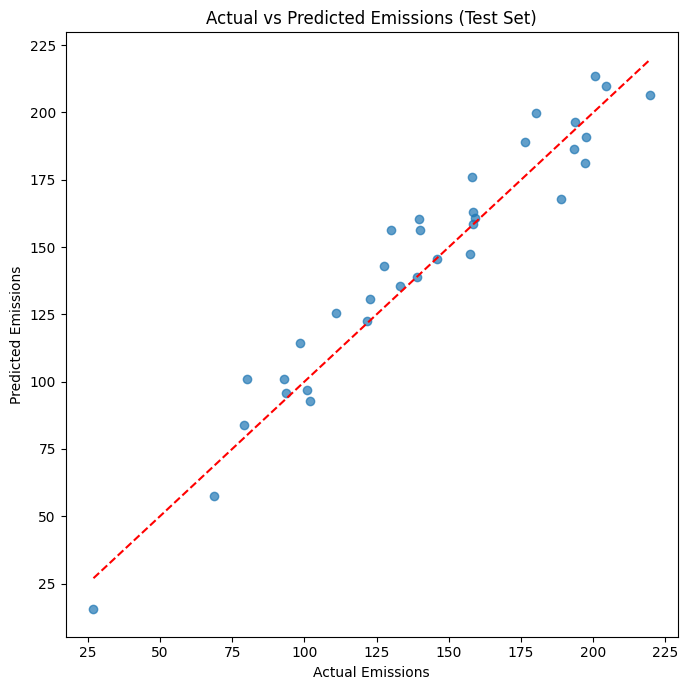

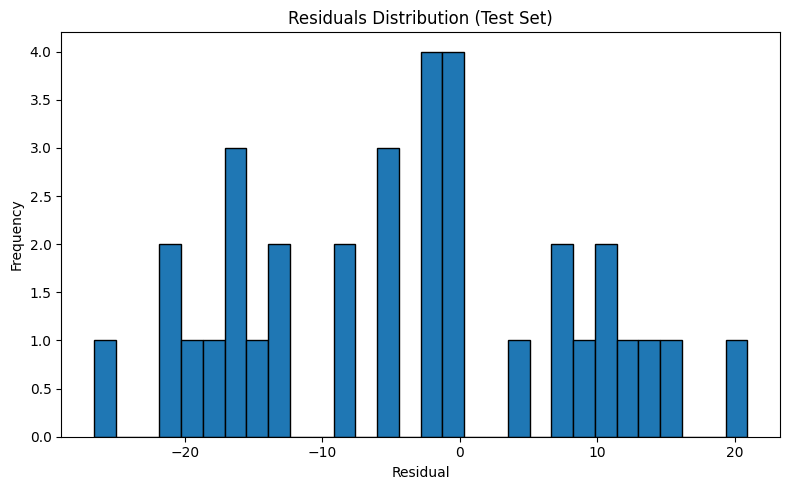

Linear model trained
Training MSE: 1047052.27
Validation MSE: 2009329.92
Testing MSE: 983353.36
Training R²: 0.940
Validation R²: 0.95
Testing R²: 0.94
Testing MAE: 831.10


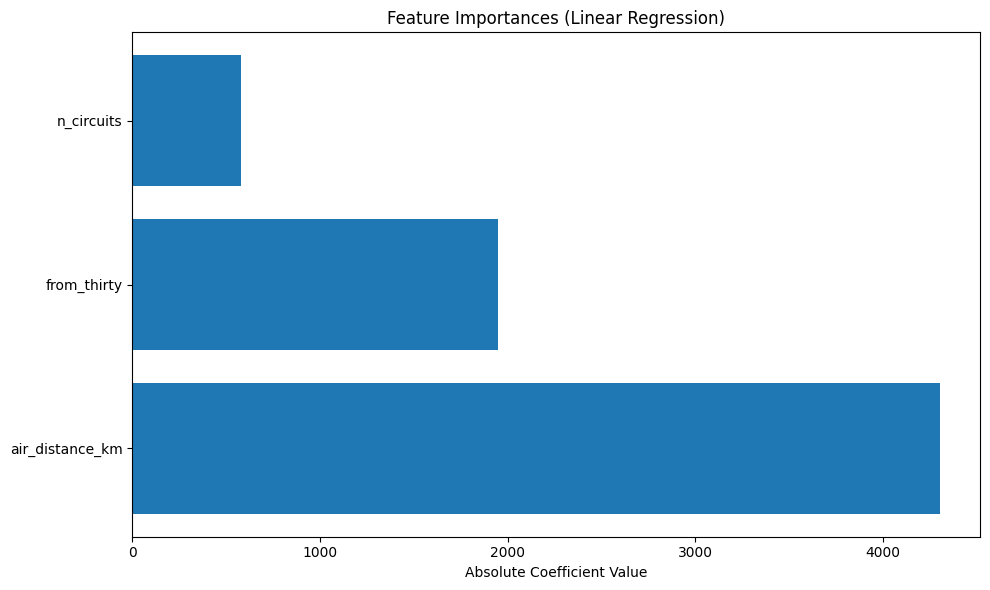

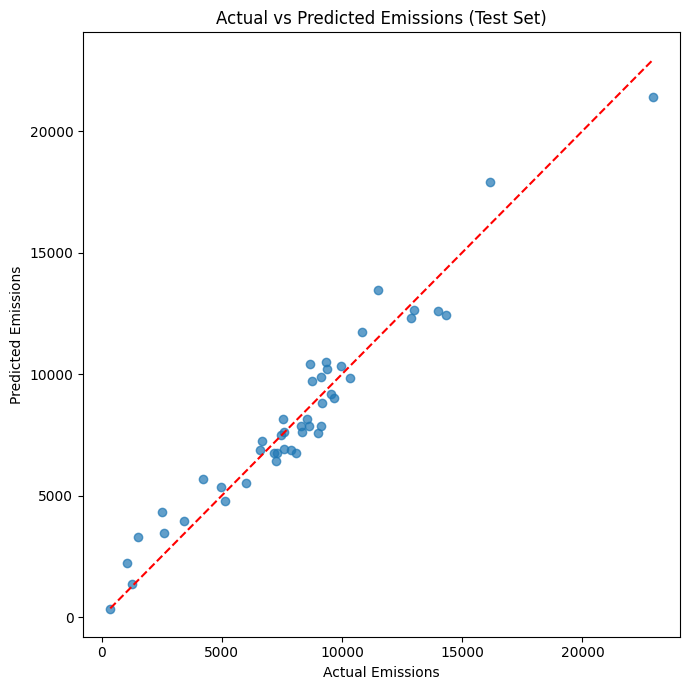

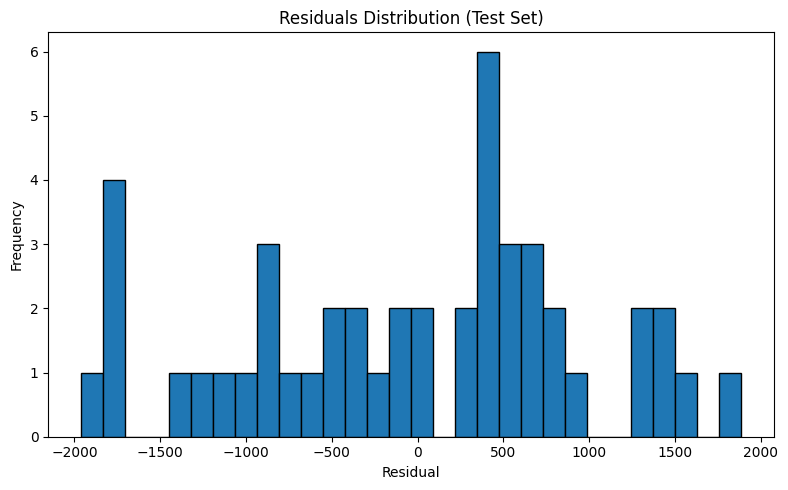

In [34]:
truck_trained, truck_feature_names, truck_feature_importance, truck_performance, truck_feature_explanation = train_regression_model(training_set=training_set_truck)
air_trained, air_feature_names, air_feature_importance, air_performance, air_feature_explanation = train_regression_model(training_set=training_set_air)

In [ ]:
a = generate_features(n_random=20, year=2026, verbose=True)
ls = a['codes'].str[:6].to_list()

2025-05-25 10:42:58,539 - INFO - get_table - Executing function: get_table
2025-05-25 10:42:58,552 - INFO - get_table - Completed function: get_table
2025-05-25 10:42:58,553 - INFO - get_table - Executing function: get_table
2025-05-25 10:42:58,556 - INFO - get_table - Completed function: get_table
2025-05-25 10:42:58,556 - INFO - get_table - Executing function: get_table
2025-05-25 10:42:58,562 - INFO - get_table - Completed function: get_table
Randomly selected 20 circuits: ['SINMAR', 'NOROSL', 'CANVAN', 'NIGLAG', 'AZEBAK', 'QATLUS', 'FRALEC', 'SPAVAL', 'MONMON', 'FRAMAG', 'GERHOC', 'BAHSAK', 'JAPOYA', 'MALKUA', 'BRASAO', 'JAPSUZ', 'ARGBUE', 'USACHI', 'MALKUT', 'ITAIMO']


In [ ]:
b = generate_features(codes=ls, year=2026, verbose=True)

2025-05-25 10:50:21,871 - INFO - get_table - Executing function: get_table
2025-05-25 10:50:21,886 - INFO - get_table - Completed function: get_table
2025-05-25 10:50:21,888 - INFO - get_table - Executing function: get_table
2025-05-25 10:50:21,890 - INFO - get_table - Completed function: get_table
2025-05-25 10:50:21,890 - INFO - get_table - Executing function: get_table
2025-05-25 10:50:21,897 - INFO - get_table - Completed function: get_table
Using provided codes: ['SINMAR', 'NOROSL', 'CANVAN', 'NIGLAG', 'AZEBAK', 'QATLUS', 'FRALEC', 'SPAVAL', 'MONMON', 'FRAMAG', 'GERHOC', 'BAHSAK', 'JAPOYA', 'MALKUA', 'BRASAO', 'JAPSUZ', 'ARGBUE', 'USACHI', 'MALKUT']


In [ ]:
b.head(1)

,codes,id,from_circuit,to_circuit,air_distance_km,truck_distance_km,truck_feasible,from_thirty,from_latitude,from_longitude,to_latitude,to_longitude,n_circuits
0,SINMAR-NOROSL,656,Marina Bay,Oslo,10056.660499,NaN,0,4,1.2914,103.8645,59.9139,10.7522,19


In [ ]:
def calendar_emissions(code_seq: list, season_year: int, air_model, truck_model):
    """
    Apply the trained regression model to predict leg emissions for a DataFrame.
    Returns the DataFrame with a new 'predicted_leg_emissions' column.
    """
    # Get trained model and encoders from the parameters
    if air_model is None or truck_model is None:
        raise ValueError("Air and Truck models must be provided for prediction.")

    if not isinstance(code_seq, list) or len(code_seq) < 2:
        raise ValueError("Input must be a list of at least two circuit codes.")
    
    if not isinstance(season_year, int):
        raise ValueError("Season year must be an integer.")

    # Generate features for the sequence of circuits
    features = generate_features(codes=code_seq, year=season_year, verbose=False)

    features_air = features[features['truck_feasible'] == False].copy()
    features_truck = features[features['truck_feasible'] == True].copy()

    features_air = features_air.drop(columns=['from_latitude', 'from_longitude', 'to_latitude', 'to_longitude','truck_feasible','truck_distance_km'])
    features_truck = features_truck.drop(columns=['air_distance_km', 'truck_feasible','from_latitude', 'from_longitude', 'to_latitude', 'to_longitude'])

# Select features for the regression
    if 'air_distance_km' not in features.columns and 'truck_distance_km' not in features.columns:
        raise ValueError("Training set must contain 'air_distance_km' or 'truck_distance_km' columns.")

    selected_features_air = features_air[['from_circuit', 'to_circuit', 'air_distance_km', 'from_thirty','n_circuits']].copy()
    numerical_columns_air = ['air_distance_km', 'from_thirty', 'n_circuits']

    selected_features_truck = features_truck[['from_circuit', 'to_circuit', 'truck_distance_km', 'from_thirty','n_circuits']].copy()
    numerical_columns_truck = ['truck_distance_km', 'from_thirty', 'n_circuits']


    selected_features_air = selected_features_air.fillna(0)
    selected_features_truck = selected_features_truck.fillna(0)

    # scale numerical features
    scaler = StandardScaler()
    selected_features_air[numerical_columns_air] = scaler.fit_transform(
        selected_features_air[numerical_columns_air]
    )

    selected_features_truck[numerical_columns_truck] = scaler.fit_transform(
        selected_features_truck[numerical_columns_truck]
    )

    selected_features_air = selected_features_air.drop(['from_circuit', 'to_circuit'], axis='columns')
    selected_features_truck = selected_features_truck.drop(['from_circuit', 'to_circuit'], axis='columns')
    
    x_air = selected_features_air
    x_truck = selected_features_truck
    
    # Make predictions
    predictions_air = air_model.predict(x_air)
    predictions_truck = truck_model.predict(x_truck)


    # predictions_air['truck_feasible'] = False
    # predictions_truck['truck_feasible'] = True
    
    # # Combine predictions
    # predictions = np.concatenate([predictions_air, predictions_truck])
        
    return predictions_air, predictions_truck

In [ ]:
def load_models(filename_prefix='fone_regression', logger=None):
    """
    Load the trained models from disk.
    
    Returns:
        tuple: (air_model, truck_model)
    """
    air_model_path =  os.path.join(MODEL_PATH, f"{filename_prefix}_air_model.pkl")
    truck_model_path = os.path.join(MODEL_PATH, f"{filename_prefix}_truck_model.pkl")

    if not os.path.exists(air_model_path) or not os.path.exists(truck_model_path):
        raise FileNotFoundError("Model files not found. Please train and save the models first.")

    air_model = joblib.load(air_model_path)
    truck_model = joblib.load(truck_model_path)

    if logger:
        logger.info("Models loaded successfully.")

    return air_model, truck_model

In [ ]:
air_trained, truck_trained = load_models(filename_prefix='fone_regression')

In [ ]:
params = {
    'MODELS' : {
        'air_model': air_trained,
        'truck_model': truck_trained
    },
}

In [ ]:
pred_a, pred_t = calendar_emissions(code_seq=ls, season_year=2026, air_model=params['MODELS']['air_model'], truck_model=params['MODELS']['truck_model'])

2025-05-25 12:15:20,329 - INFO - get_table - Executing function: get_table
2025-05-25 12:15:20,395 - INFO - get_table - Completed function: get_table
2025-05-25 12:15:20,396 - INFO - get_table - Executing function: get_table
2025-05-25 12:15:20,407 - INFO - get_table - Completed function: get_table
2025-05-25 12:15:20,409 - INFO - get_table - Executing function: get_table
2025-05-25 12:15:20,455 - INFO - get_table - Completed function: get_table


In [ ]:
pred_a, pred_t = calendar_emissions(code_seq=ls, season_year=2026, air_model=air_trained, truck_model=truck_trained)

2025-05-25 11:19:40,679 - INFO - get_table - Executing function: get_table
2025-05-25 11:19:40,699 - INFO - get_table - Completed function: get_table
2025-05-25 11:19:40,700 - INFO - get_table - Executing function: get_table
2025-05-25 11:19:40,705 - INFO - get_table - Completed function: get_table
2025-05-25 11:19:40,707 - INFO - get_table - Executing function: get_table
2025-05-25 11:19:40,713 - INFO - get_table - Completed function: get_table


In [ ]:
pred_a

array([ 9209.56986181,  6869.69861823, 10746.00612353,  5866.32835139,
        2377.41367779,  4738.16260506,  4625.68184093,  7728.98960339,
        5315.72332372, 13965.76152256, 16273.99874568, 16204.66545646,
        8359.44025249, 12950.4421009 ])

In [ ]:
pred_t

array([153.93858781, 198.17058775, 104.01056989,  82.5991123 ])

In [ ]:
import joblib
MODEL_PATH = model_path
def save_models(air_model, truck_model, filename_prefix='fone_regression'):
    """
    Save the trained models to disk in the specified model_path directory.
    """
    joblib.dump(air_model, os.path.join(MODEL_PATH, f"{filename_prefix}_air_model.pkl"))
    joblib.dump(truck_model, os.path.join(MODEL_PATH, f"{filename_prefix}_truck_model.pkl"))

    print("Models and scalers saved successfully.")

In [ ]:
save_models(air_trained, truck_trained, filename_prefix='fone_regression')

Models and scalers saved successfully.
